### This creates the dataset.

As you see, the true number of modes is three.
Of course you didn't know this, as I gave you the file...

In [17]:
# Based on Fig 4.2 in the textboox 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=13, usetex=True)

# Set a seed for reproducibility
random_state = np.random.RandomState(seed=1)

import os

In [18]:
X = np.concatenate([random_state.normal(9, 5, 350),
                    random_state.normal(20, 1, 600),
                    random_state.normal(30, 5, 2000)]).reshape(-1, 1)

if not os.path.isfile("formationchannels.npy"):
    np.save("formationchannels.npy",X)


You start from here...

### Quick data exploration

(always explore the data before starting)

In [19]:
X=np.load("formationchannels.npy")

[[17.12172682]
 [ 5.94121793]
 [ 6.35914124]
 ...
 [34.34170191]
 [30.27018478]
 [25.93264098]]


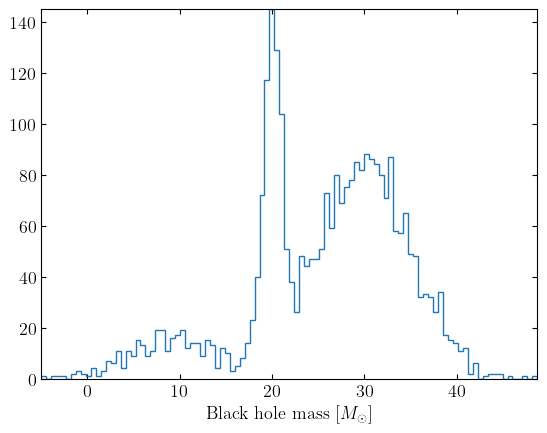

In [20]:
plt.hist(X,bins=100,histtype='step');
plt.xlabel("Black hole mass $[M_\odot]$")
print(X)

### Learn the best-fit GaussianMixture models

Here we'll use scikit-learn's GaussianMixture model. The fit() method uses an [Expectation-Maximization approach](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) to find the best mixture of Gaussians for the data

In [21]:
# fit models with 1-10 components
N = np.arange(1, 10)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

### Compute the AIC. 
It's built in into sklearn.mixture.GaussianMixture  but otherwise you can easily compute it from the maximum likelihood


In [22]:
AIC = [m.aic(X) for m in models]

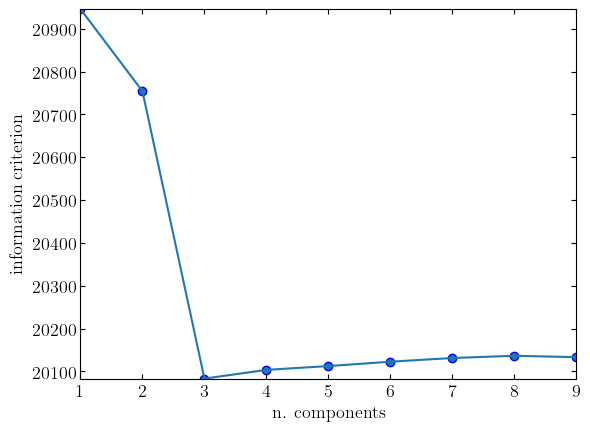

In [23]:
plt.plot(N, AIC,)
plt.scatter(N, AIC)

plt.xlabel('n. components')
plt.ylabel('information criterion');

In [24]:
print('The AIC is minimized for N=', N[np.argmin(AIC)])

The AIC is minimized for N= 3


which is indeed is our true value. 

### Explore results

Let's plot this specific solution now:

Text(0.5, 0, 'Black hole mass $[M_\\odot]$')

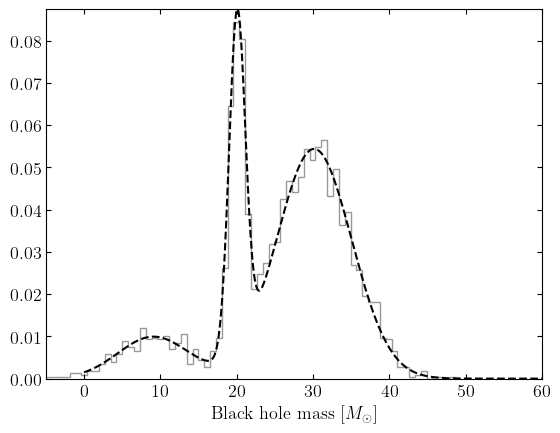

In [25]:
M_best = models[np.argmin(AIC)]

x = np.linspace(0, 60, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)

plt.hist(X, 70, density=True, histtype='step', alpha=0.4,color='black')

plt.plot(x, pdf, '--k')

plt.xlabel("Black hole mass $[M_\odot]$")

That's a nice fit! Let's add the individual modes now.

Text(0.5, 0, 'Black hole mass $[M_\\odot]$')

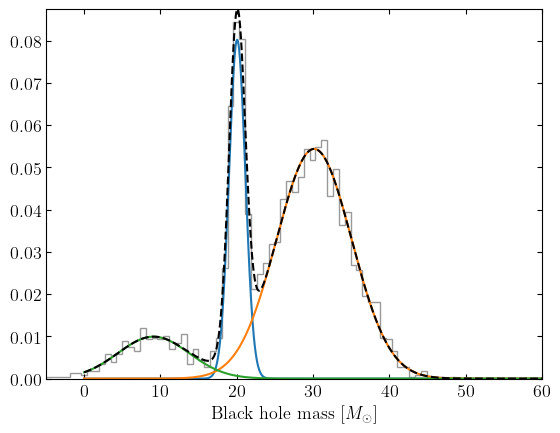

In [26]:
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(X, 70, density=True, histtype='step', alpha=0.4,color='black')
plt.plot(x, pdf_individual[:,0], c='C0')
plt.plot(x, pdf_individual[:,1], c='C1')
plt.plot(x, pdf_individual[:,2], c='C2')
plt.plot(x, pdf, '--k')

plt.xlabel("Black hole mass $[M_\odot]$")

Another way of representing the responsibilities

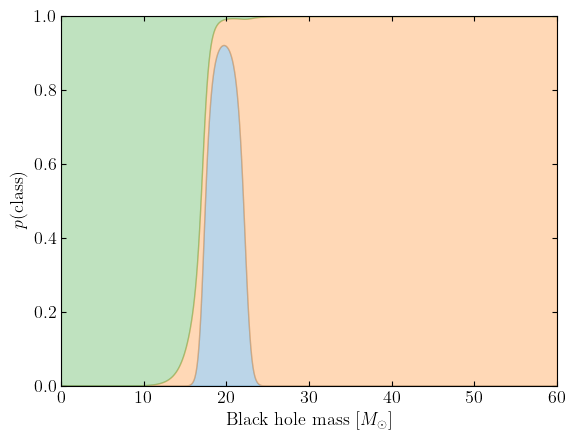

In [27]:
p = responsibilities
#p = p[:, (0, 1, 2)]  # rearrange order so the plot looks better
p = p.cumsum(axis=1).T

plt.fill_between(x, 0, p[0], color='C0', alpha=0.3)
plt.fill_between(x, p[0], p[1], color='C1', alpha=0.3)
plt.fill_between(x, p[1], 1, color='C2', alpha=0.3)
#plt.xlim(-6, 6)
plt.ylim(0, 1)
plt.xlabel("Black hole mass $[M_\odot]$")

plt.ylabel(r'$p({\rm class})$');

#plt.text(-5, 0.3, 'class 1', rotation='vertical')
#plt.text(0, 0.5, 'class 2', rotation='vertical')
#plt.text(3, 0.3, 'class 3', rotation='vertical')


I noticed the AIC is basically flat past N=3. Let's compare results with an additional mode

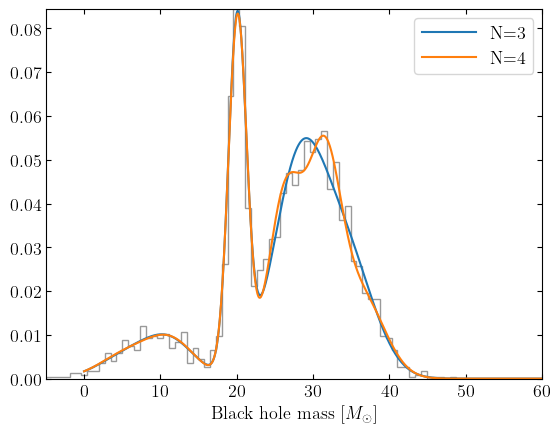

In [28]:
plt.hist(X, 70, density=True, histtype='step', alpha=0.4,color='black')

logprob = models[4].score_samples(x.reshape(-1, 1))
plt.plot(x, np.exp(logprob),label='N=3')

logprob = models[5].score_samples(x.reshape(-1, 1))
plt.plot(x, np.exp(logprob),label='N=4')

plt.xlabel("Black hole mass $[M_\odot]$")
plt.legend();

Indeed, that's a pretty good fit! Maybe even better? At this point I will want to try with a different goodness-of-fit estimator. [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) is a variant of AIC which is also implemented in sklearn. 

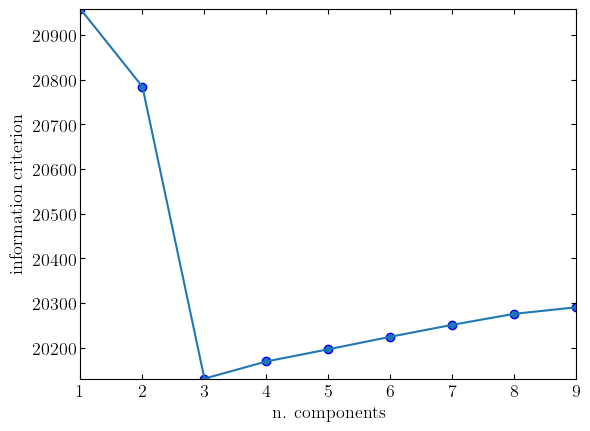

In [72]:
BIC = [m.bic(X) for m in models]
plt.plot(N, BIC,)
plt.scatter(N, BIC)
plt.xlabel('n. components')
plt.ylabel('information criterion');

This also says N=3.